In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', unicode=True)
rc('text.latex', preamble=r'\usepackage[english,russian]{babel}')

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
res_com_cnn_camus = pd.read_csv('cnn/results/com_unet_camus.csv')['dice']
res_mod_cnn_camus = pd.read_csv('cnn/results/mod_unet_camus.csv')['dice']
res_com_cnn_camus_usekb = pd.read_csv('cnn/results/com_unet_camus+usekb.csv')['dice']
res_mod_cnn_camus_usekb = pd.read_csv('cnn/results/mod_unet_camus+usekb.csv')['dice']
res_lucaskanade = pd.read_csv('optical_flow/results/lk.csv')['30']
res_levelset = pd.read_csv('level_set/results/ls.csv')['80']
res_gac = pd.read_csv('level_set/results/gac.csv')['450']
res_morpology = pd.read_csv('morphology/results/result.csv')['dice']
all_res = {'m_UNet_CAMUS' : {'dist' : res_mod_cnn_camus, 'h' : 0.007}, 
           'c_UNet_CAMUS' : {'dist' : res_com_cnn_camus, 'h' : 0.0099}, 
           'm_UNet_CAMUS_USEKB' : {'dist' : res_mod_cnn_camus_usekb, 'h' : 0.0077}, 
           'c_UNet_CAMUS_USEKB' : {'dist' : res_com_cnn_camus_usekb, 'h' : 0.00919}, 
           'Lucas Kanade' : {'dist' : res_lucaskanade, 'h' : 0.007}, 
           'Level set' : {'dist' : res_levelset, 'h' : 0.00830}, 
           'Morphology' : {'dist' : res_morpology, 'h' : 0.0053},
           'GAC' : {'dist' : res_gac, 'h' : 0.0093},
          }

In [4]:
# f = pd.read_csv('f_f.csv')
# lx = pd.read_csv('lx_f.csv')

In [5]:
# kernels = {
#     'c_UNet_CAMUS'  : {'kernel' : 'kernelLaplace', 'H' : 0.0116, 'Ji' : -0.2090},
#     'm_UNet_CAMUS' : {'kernel' : 'kernelLaplace', 'H' : 0.0127, 'Ji' : -0.1134},
#     'c_UNet_CAMUS_USEKB' : {'kernel' : [], 'H' : [], 'Ji' : []},
#     'm_UNet_CAMUS_USEKB' : {'kernel' : [], 'H' : [], 'Ji' : []},
#     'Lucas Kanade' : {'kernel' : 'kernelLaplace', 'H' : 0.0084, 'Ji' : -0.4398},
#     'Morphology' : {'kernel' : 'kernelLaplace', 'H' : 0.0085, 'Ji' : -0.4259},
#     'Level set' : {'kernel' : 'kernelNorm', 'H' : 0.0207, 'Ji' : -0.5237},
#     'GAC' : {'kernel' : 'kernelLogist', 'H' : 0.0115, 'Ji' : -0.1923},
# }

In [6]:
import matplotlib.pyplot as plt

dist_norm = lambda x : np.exp(- x ** 2 / 2) / (2 * np.pi) ** (1/2) 

def pz_approx(a, h, kernel, nums):
    t = np.linspace(min(a), max(a), nums)
    f = np.zeros(t.shape)
    for i in range(len(t)):
        for j in range(len(a)):
            f[i] += 1 / (len(a) * h) * np.sum(kernel((t[i] - a[j]) / h))
    return f

def get_quartiles(x, a):
    y = np.cumsum(a) / np.sum(a)
    indexes = np.argsort(abs(y - 0.05))[:2]
    q5 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.5))[:2]
    q50 = x[indexes][0]
    indexes = np.argsort(abs(y - 0.95))[:2]
    q95 = x[indexes][0]
    return q5, q50, q95

In [7]:
for it, k in tqdm(enumerate(all_res.keys()), total=len(all_res.keys())):
    direction = 1e-4
    a = np.array(all_res[k]['dist'])
    f = -np.Inf
    h = 0.01
    flag = True
    while abs(direction) >= 1e-5: 
        l = []
        h += direction
        if h <= 0:
            print('!')
            break 
        for i in range(len(a)):
            l.append(np.log(np.sum([dist_norm((a[i] - a[j]) / h) for j in range(len(a)) if i != j]) / (len(a) - 1) / h))
        r = np.sum(l) / len(a)              
        if r < f:
            h -= direction
            if flag:
                direction = -direction
                flag = False
            else:
                direction = direction * 1e-1
        else:
            f = r
    all_res[k]['h'] = h

100%|██████████| 8/8 [1:07:20<00:00, 505.02s/it]


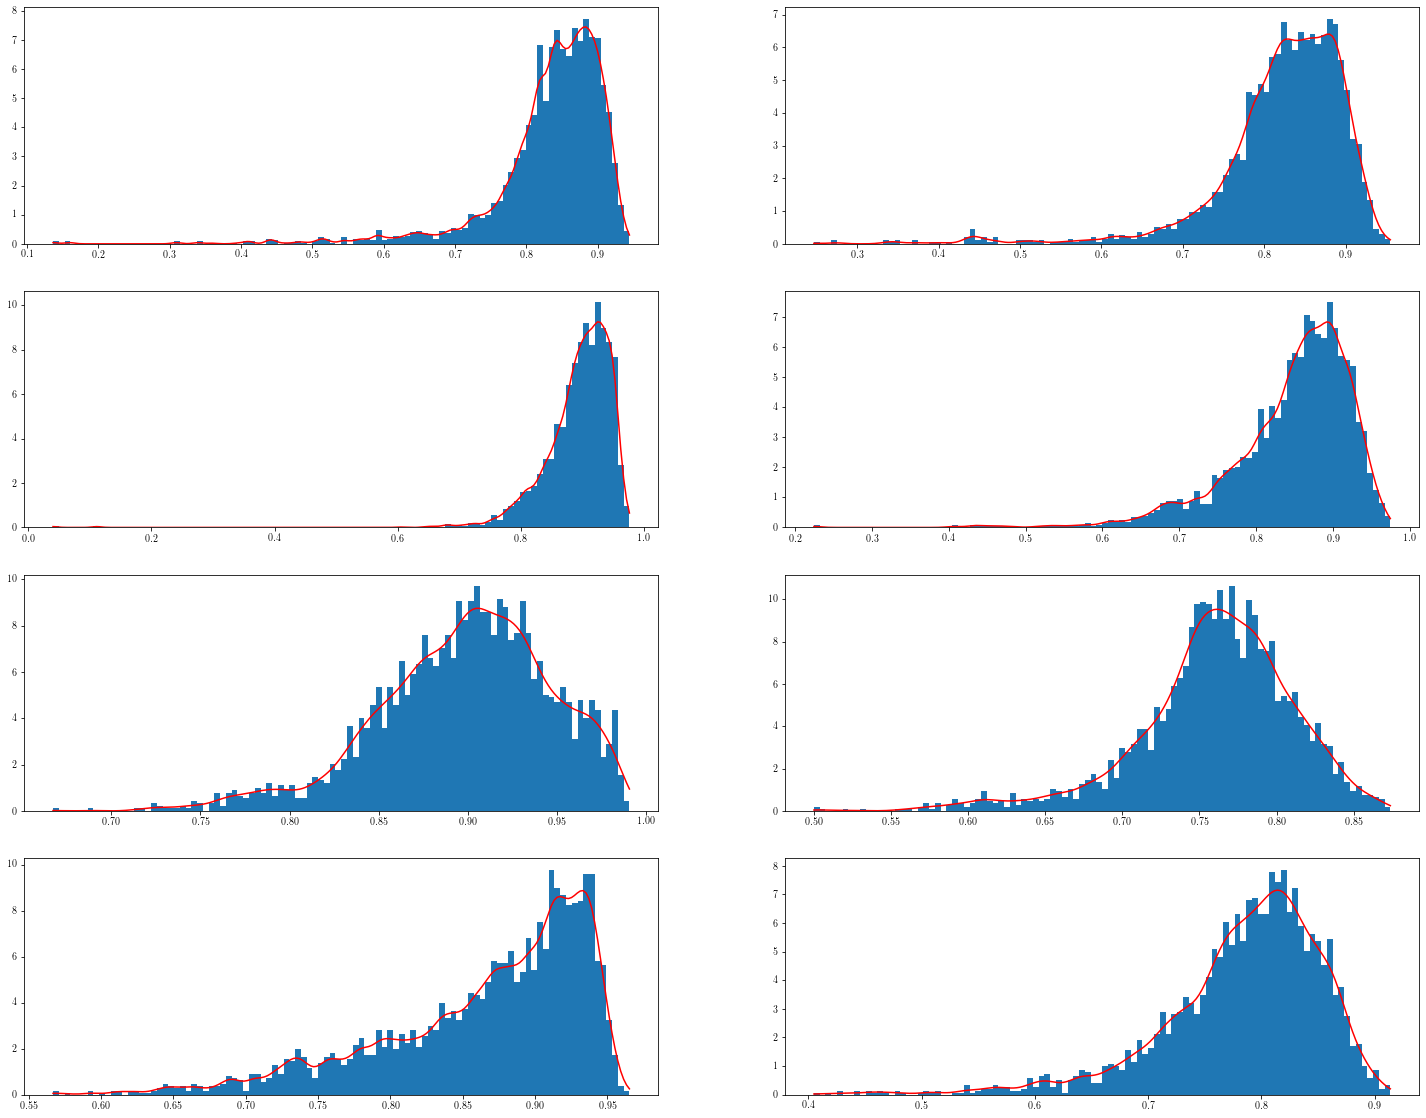

In [26]:
plt.figure(figsize=(25,20))
width = 2
num_points = 200
df_quartiles = pd.DataFrame(index = ['q5', 'q50', 'q95', 'div'], columns=all_res.keys())


for i, k in enumerate(all_res.keys()):
    a = np.array(all_res[k]['dist'])
    
    plt.subplot(np.ceil(len(all_res) / width), width, i+1)
    hist, x, *_ = np.histogram(a, bins=100);
    hist = hist / sum(hist) / (x[1] - x[0])
    plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
    t = np.linspace(min(a), max(a), num_points)
    f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
    q5, q50, q95 = get_quartiles(t, f)
    df_quartiles[k]['q5'] = q5
    df_quartiles[k]['q50'] = q50
    df_quartiles[k]['q95'] = q95
    df_quartiles[k]['div'] = q95 - q5
    plt.plot(t, f, 'r')

# for i, k in enumerate(all_res.keys()):
#     plt.subplot(np.ceil(len(all_res) / width), width, i+1)
#     hist, x, *_ = np.histogram(all_res[k]['dice'], range=[0,1], bins=100);
#     hist = hist / sum(hist) / (x[1] - x[0])
#     plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
#     if k in f.columns and k in lx.columns:
#         plt.plot(lx[k], f[k], 'r')
#         x = np.array([lx[k][i] + (lx[k][i+1] - lx[k][i]) / 2 for i in range(len(f[k]) - 1)])
#         y = np.cumsum([(f[k][i+1] + f[k][i]) / 2 * (lx[k][i+1] - lx[k][i]) for i in range(len(f[k]) - 1)])
#         indexes = np.argsort(abs(y - 0.05))[:2]
#         q5 = x[indexes][0] - (x[indexes][1] - x[indexes][0]) * y[indexes][0] / (y[indexes][1] + y[indexes][0])
#         df_quartiles[k]['q5'] = q5
# #         plt.fill_between(lx[k], f[k])
# #         plt.vlines(q5, 0, max(f[k]), colors='g')
#         indexes = np.argsort(abs(y - 0.5))[:2]
#         q50 = x[indexes][0] - (x[indexes][1] - x[indexes][0]) * y[indexes][0] / (y[indexes][1] + y[indexes][0])
#         df_quartiles[k]['q50'] = q50
# #         plt.vlines(q50, 0, max(f[k]), colors='r')
#         indexes = np.argsort(abs(y - 0.95))[:2]
#         q95 = x[indexes][0] - (x[indexes][1] - x[indexes][0]) * y[indexes][0] / (y[indexes][1] + y[indexes][0])
#         df_quartiles[k]['q95'] = q95
# #         plt.vlines(q95, 0, max(f[k]), colors='g')
#         df_quartiles[k]['div'] = q95 - q5
#         #     plt.text(0, 1, ' Среднее значение {:0.3f}'.format(r['dice'].mean()))
# #     plt.title(k)

In [107]:
ends = 'eps'
figsize=(8,4)

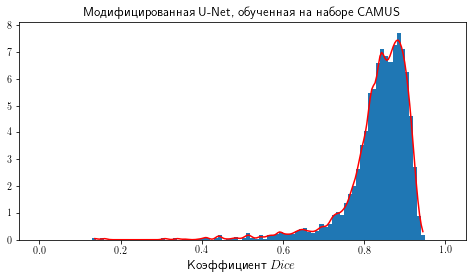

In [108]:
plt.figure(figsize=figsize)
k = 'm_UNet_CAMUS'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.title(r'Модифицированная U-Net, обученная на наборе CAMUS', fontsize=13)
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.savefig('analysis/dist_mod_unet_camus.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

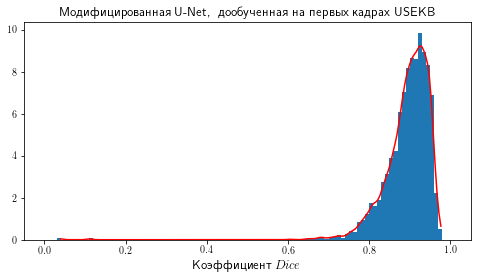

In [109]:
plt.figure(figsize=figsize)
k = 'm_UNet_CAMUS_USEKB'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.title('Модифицированная U-Net, \\ дообученная на первых кадрах USEKB', fontsize=13)
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.savefig('analysis/dist_mod_unet_camus_usekb.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

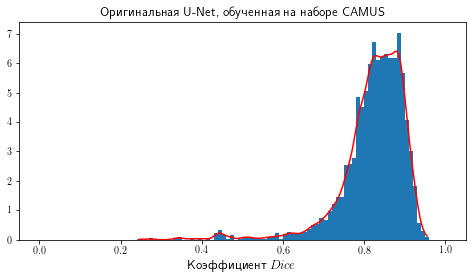

In [110]:
plt.figure(figsize=figsize)
k = 'c_UNet_CAMUS'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.title(r'Оригинальная U-Net, обученная на наборе CAMUS', fontsize=13)
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.savefig('analysis/dist_com_unet_camus.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

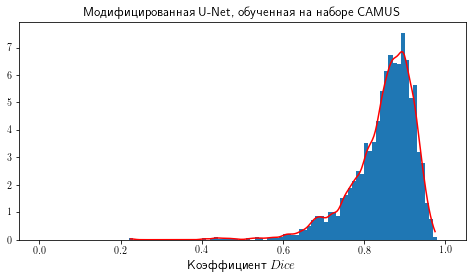

In [111]:
plt.figure(figsize=figsize)
k = 'c_UNet_CAMUS_USEKB'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.title(r'Модифицированная U-Net, обученная на наборе CAMUS', fontsize=13)
plt.savefig('analysis/dist_com_unet_camus_usekb.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

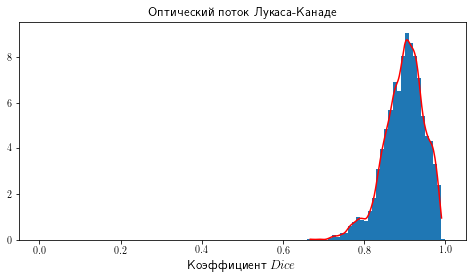

In [112]:
plt.figure(figsize=figsize)
k = 'Lucas Kanade'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.title(r'Оптический поток Лукаса-Канаде', fontsize=13)
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.savefig('analysis/dist_lucas_kanade.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

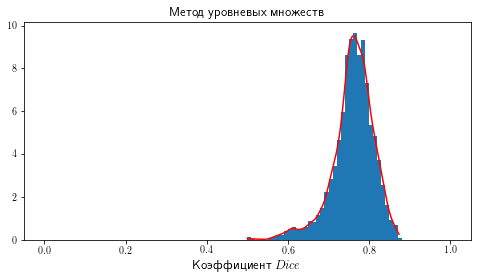

In [113]:
plt.figure(figsize=figsize);
k = 'Level set'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.title(r'Метод уровневых множеств', fontsize=13)
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.savefig('analysis/dist_level_set.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

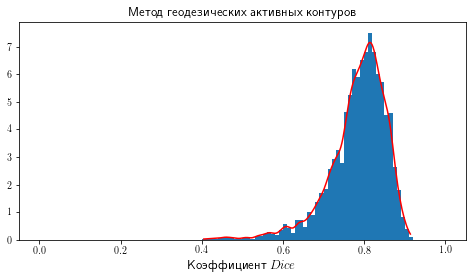

In [114]:
plt.figure(figsize=figsize)
k = 'GAC'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.title(r'Метод геодезических активных контуров', fontsize=13)
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.savefig('analysis/dist_gac.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

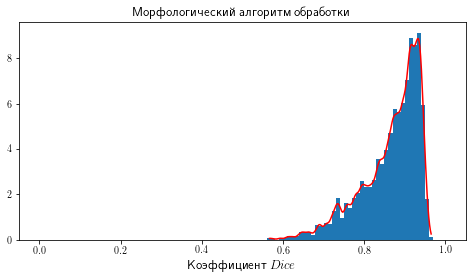

In [115]:
plt.figure(figsize=figsize)
k = 'Morphology'
a = all_res[k]['dist']
hist, x, *_ = np.histogram(a, range=[0,1], bins=100);
hist = hist / sum(hist) / (x[1] - x[0])
plt.bar([(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)], hist, width=(x[1] - x[0]))
t = np.linspace(min(a), max(a), num_points)
f = pz_approx(a, all_res[k]['h'], dist_norm, num_points)
plt.plot(t, f, 'r')
plt.title(r'Морфологический алгоритм обработки', fontsize=13)
plt.xlabel(r'Коэффициент $Dice$', fontsize=13)
plt.savefig('analysis/dist_morph.'+ends, dpi=300, bbox_inches='tight', pad_inches=0)

In [35]:
df_quartiles

,m_UNet_CAMUS,c_UNet_CAMUS,m_UNet_CAMUS_USEKB,c_UNet_CAMUS_USEKB,Lucas Kanade,Level set,Morphology,GAC
q5,0.684754,0.688005,0.793229,0.691998,0.807067,0.663493,0.720963,0.650463
q50,0.847249,0.834003,0.901514,0.861678,0.901347,0.76298,0.885117,0.796256
q95,0.91631,0.912343,0.953302,0.937091,0.971244,0.832434,0.943171,0.87299
div,0.231556,0.224337,0.160073,0.245093,0.164177,0.168941,0.222209,0.222527


In [24]:
0.8324 - 0.663493

0.16890700000000003

In [25]:
0.87299 - 0.650463

0.22252700000000003

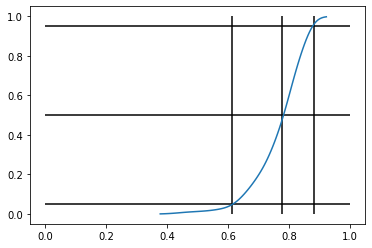

In [88]:
plt.plot(x, y)
plt.vlines(df_quartiles[k]['q5'], 0, 1)
plt.hlines(0.05, 0, 1)
plt.vlines(df_quartiles[k]['q50'], 0, 1)
plt.hlines(0.5, 0, 1)
plt.vlines(df_quartiles[k]['q95'], 0, 1)
plt.hlines(0.95, 0, 1)

In [31]:
df = pd.concat((res_com_cnn['dice'], res_mod_cnn['dice'], res_lucaskanade['dice'], res_morpology['dice'],), axis=1)
df.columns = ['com_cnn', 'mod_cnn', 'lk', 'morph']
df.to_csv('for_pr_1.csv', header=True, index=False,)